# Use SetFit for Active Learning with Small-Text

*Notebook 4*  
In this tutorial we demonstrate how to use cold start initialization with [SetFit](https://github.com/huggingface/setfit), i.e. we start active learning directly without having to provide an initial set of labels.

----

## Overview

- [Part I: Introduction and Installation](#nb4-part1-introduction)
- [Part II: Loading, Investigating, and Preparing the AG's News Dataset](#nb4-part2-data)
- [Part III: Active Learning](#nb4-part3-active-learning)
- [Part IV: Plotting the results](#nb4-part4-evaluation)

----

<a id="nb4-part1-introduction"></a>
## I. Introduction

By *SetFit* we refer to the method by Tunstall et al. from the paper [Efficient Few-Shot Learning Without Prompts](https://arxiv.org/pdf/2209.11055.pdf). SetFit is an efficient approach that is based on constrative fine-tuning on sentence-transformer embeddings. In small-text, the [Hugging Face SetFit implementation](https://github.com/huggingface/setfit) is wrapped so that you can you use with all existing small-text components.

### Installation and Preparation

The small-text wrapper for SetFit is a part of the transformers integration, so the installation procedure is the same as for every other example that shows small-text with transformers. 

In [1]:
%pip install small-text[transformers]==1.4.0

# setfit is an optional dependency and must be installed as well
%pip install setfit==0.7.0
%pip install datasets
%pip install matplotlib

import logging

import datasets
import matplotlib.pyplot as plt

plt.rc('figure', titlesize=22)
plt.rc('axes', titlesize=22, labelsize=20, linewidth=1.2)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=16)
plt.rc('lines', linewidth=2)

datasets.logging.set_verbosity_error()

# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

for logger_name in ['setfit.modeling', 'setfit.trainer']:
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.ERROR)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----

<a id="nb4-part2-data"></a>
## II. Loading the Data

We use the "AG's News" dataset for this demonstration. It consists of news articles which are categorized into four mutually exclusive classes.

In [2]:
import datasets
import logging
import numpy as np


# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

raw_dataset = datasets.load_dataset('ag_news')
num_classes = np.unique(raw_dataset['train']['label']).shape[0]

print('First 10 training samples:\n')
for i in range(10):
    print(raw_dataset['train']['label'][i], ' ', raw_dataset['train']['text'][i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1155.93it/s]


First 10 training samples:

2   Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
2   Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
2   Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
2   Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.
2   Oil prices soar to all-time record, posing new men

In [3]:
print(raw_dataset['train'].features['label'])

ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)


### Preparing the Data

The SetFit Classifier uses the `TextData` structure as input. Such datasets can be easily created from raw text and labels using `TextDataset.from_arrays()`.

In [4]:
import numpy as np
from small_text import TextDataset

num_classes = raw_dataset['train'].features['label'].num_classes

target_labels = np.arange(num_classes)

train = TextDataset.from_arrays(raw_dataset['train']['text'], np.array(raw_dataset['train']['label']), target_labels=target_labels)
test = TextDataset.from_arrays(raw_dataset['test']['text'], np.array(raw_dataset['test']['label']), target_labels=target_labels)

/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/small_text/utils/annotations.py:67: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  warnings.warn(f'The {subject} {func_or_class.__name__} is experimental '


----

<a id="nb4-part3-active-learning"></a>
## III. Active Learning

First, we setup the classifier. Compared to the previous notebook examples, we use the SetFit factory and model arguments instead of the transformer-based variants.

In [5]:
# TODO: use short imports
from small_text.integrations.transformers.classifiers.setfit import SetFitModelArguments
from small_text.integrations.transformers.classifiers.factories import SetFitClassificationFactory

sentence_transformer_model_name = 'sentence-transformers/paraphrase-mpnet-base-v2'
setfit_model_args = SetFitModelArguments(sentence_transformer_model_name)

clf_factory = SetFitClassificationFactory(setfit_model_args, 
                                          num_classes)

## Setting up the Active Learner

Here, we construct a `PoolBasedActiveLearner` instance which requires a classifier factory, a query strategy, and the train dataset.

To obtain a first model, we initialize the active learner by providing the true labels for 20 sentences. This corresponds to an initial labeling the real-world setting.

In [6]:
from small_text import (
    PoolBasedActiveLearner, 
    BreakingTies,
    SubsamplingQueryStrategy
)

# define a query strategy and initialize a pool-based active learner
query_strategy = SubsamplingQueryStrategy(BreakingTies())

def initialize_with_coldstart():
    cold_start_labels = np.array([0, 1, 2, 3])
    cold_start_dataset = TextDataset.from_arrays([
            'This is about world news.',
            'This is about sports.',
            'This is about business.',
            'This is about science and technology.'
        ], 
        cold_start_labels,
        target_labels=target_labels)

    train = TextDataset.from_arrays(cold_start_dataset.x + raw_dataset['train']['text'], 
                                    np.append(cold_start_labels, np.array(raw_dataset['train']['label'])), 
                                    target_labels=target_labels)
    
    # suppress progress bars in jupyter notebook
    setfit_train_kwargs = {'show_progress_bar': False}

    active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train, fit_kwargs={'setfit_train_kwargs': setfit_train_kwargs})
    
    clf = clf_factory.new()
    clf.fit(cold_start_dataset, setfit_train_kwargs=setfit_train_kwargs)

    active_learner.initialize(clf)

    return active_learner, train


active_learner, train = initialize_with_coldstart()

### Active Learning

The main active learning loop queries the unlabeled pool and thereby decides which documents are labeled next.
We then provide the labels for those documents and the active learner retrains the model.
After each query, we evaluate the current model against the test set and save the result.


Note: This is active learning as it is done in a scientific simulation. In reality, the label feedback would have been given by human annotators.

#### Active Learning Loop

In [7]:
import gc
import torch
from sklearn.metrics import accuracy_score


num_queries = 10


def evaluate(active_learner, train, test):
    
    if len(train) == 0:
        return np.nan
    
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))
    
    return test_acc


results_setfit = []
results_setfit.append(evaluate(active_learner, train[active_learner.indices_labeled], test))
   
    
for i in range(num_queries):

    # ...where each iteration consists of labelling 20 samples
    q_indices = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[q_indices]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)
    
    # memory fix: https://github.com/UKPLab/sentence-transformers/issues/487, https://github.com/UKPLab/sentence-transformers/issues/1793
    gc.collect()
    torch.cuda.empty_cache()
    
    print('---------------')
    print('Iteration #{:d} ({} samples)'.format(i, len(active_learner.indices_labeled)))
    results_setfit.append(evaluate(active_learner, train[active_learner.indices_labeled], test))



Train accuracy: 1.00
Test accuracy: 0.67
---------------
Iteration #0 (24 samples)
Train accuracy: 1.00
Test accuracy: 0.68
---------------
Iteration #1 (44 samples)
Train accuracy: 1.00
Test accuracy: 0.85
---------------
Iteration #2 (64 samples)
Train accuracy: 1.00
Test accuracy: 0.85
---------------
Iteration #3 (84 samples)
Train accuracy: 1.00
Test accuracy: 0.87
---------------
Iteration #4 (104 samples)
Train accuracy: 1.00
Test accuracy: 0.88
---------------
Iteration #5 (124 samples)
Train accuracy: 1.00
Test accuracy: 0.89
---------------
Iteration #6 (144 samples)
Train accuracy: 1.00
Test accuracy: 0.89
---------------
Iteration #7 (164 samples)
Train accuracy: 1.00
Test accuracy: 0.88
---------------
Iteration #8 (184 samples)
Train accuracy: 1.00
Test accuracy: 0.88
---------------
Iteration #9 (204 samples)
Train accuracy: 1.00
Test accuracy: 0.89


----

<a id="nb4-part4-evaluation"></a>
## IV. Plotting the Results

With the previous results we can plot a [learning curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) to visualize the performance.

<module 'matplotlib.pyplot' from '/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/matplotlib/pyplot.py'>

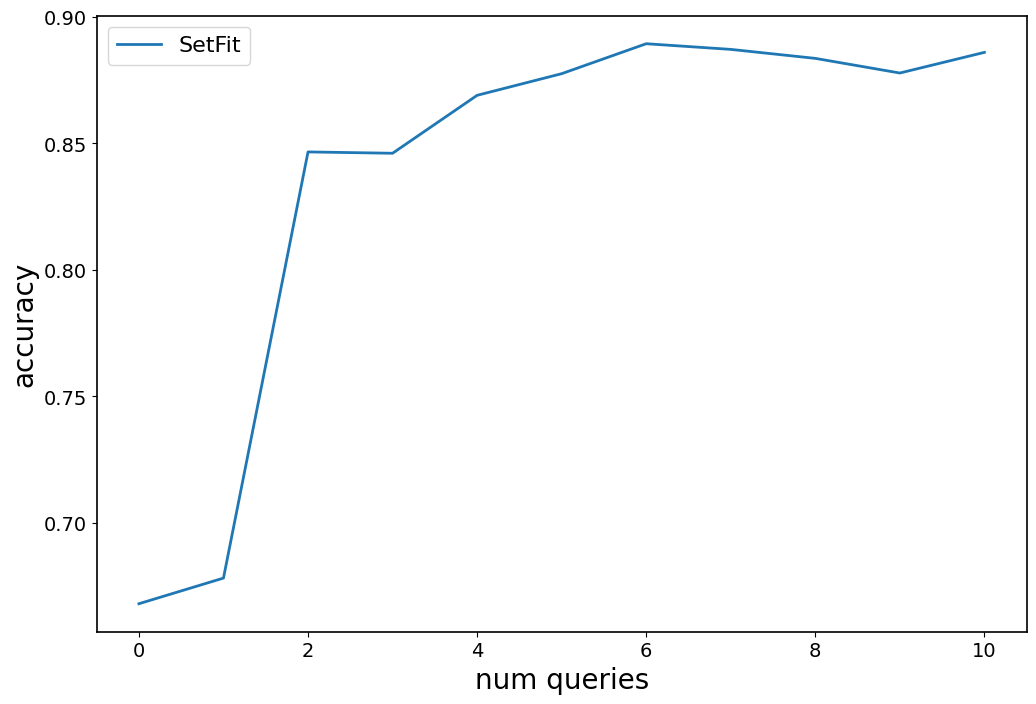

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

ax.plot(np.arange(num_queries+1), results_setfit, label='SetFit')
ax.legend()

plt.ylabel('accuracy')
plt.xlabel('num queries')

display(plt)